In [1]:
import gymnasium as gym
import torch
from src.data.services.dimensions import get_dims
import json

In [2]:
env_name = "MountainCar-v0"

In [3]:
env = gym.make(env_name)

In [4]:
from src.nn.services.dqn import DQN

In [5]:
state_dim, action_dim = get_dims(env)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
dqn_golden = DQN(state_dim, action_dim).to(device)

In [8]:
from src.training.services.train import full_training as train

/run/media/john/Secondary/Documents/Cornell/Spring 2024/CS4756 Robot Learning/il-pre-train-dqn/.venv/lib64/python3.11/site-packages/gymnasium/utils/play.py:29: UserWarning: WARN: matplotlib is not installed, run `pip install gymnasium[other]`
  logger.warn("matplotlib is not installed, run `pip install gymnasium[other]`")


In [9]:
from src.data.services.memory import ReplayMemory

In [10]:
from torch.optim import Adam

In [11]:
batch_size = 64
gamma = 0.99
num_episodes = 10000
target_update = 50
epsilon = 0.25

In [12]:
import cv2

In [13]:
def create_video(frames, fps=10, output_name="output"):
    out = cv2.VideoWriter(f"{output_name}.mp4", cv2.VideoWriter_fourcc(*'mp4v'), fps, (frames[0].shape[1], frames[0].shape[0]))
    for frame in frames:
        out.write(frame)
    out.release()

In [14]:
from src.policy.services.epsilon_greedy import epsilon_greedy

In [15]:
def test_dqn(dqn, env, device, output_name="output", output_dir="./tmpvideo"):
    frames = []
    rewards = []
    state, _ = env.reset()
    done = False
    while not done:
        frames.append(env.render())
        action = epsilon_greedy(
            torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device), dqn, 0)
        next_state, reward, terminated, truncated, _ = env.step(action)
        rewards.append(reward)
        done = terminated or truncated
        state = next_state
    create_video(frames, output_name=f"{output_dir}/{output_name}")
    return rewards

In [16]:
bf_rewards = test_dqn(dqn_golden, gym.make(env_name, render_mode="rgb_array"), device, output_name="before_training_mountain_car")

In [17]:
pretrain_path = "./src/pretrain/data/MountainCar-v0_10_000.npy"
pretrain_epochs = 100
pretrain_batch_size = batch_size
pretrain_optm_lr = 0.001
pretrain_optimizer = Adam(dqn_golden.parameters(), lr=pretrain_optm_lr)

In [18]:
from tqdm.auto import tqdm

100%|██████████| 100/100 [00:22<00:00,  4.39it/s]


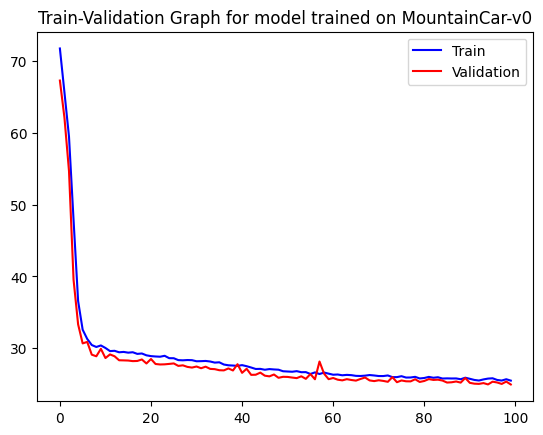

In [19]:
from src.pretrain.services.train import pre_train
pre_train(
    dqn_golden,
    pretrain_optimizer,
    pretrain_path,
    pretrain_epochs,
    pretrain_batch_size,
    device=device,
)

In [20]:
pretrain_rewards = test_dqn(dqn_golden, gym.make(env_name, render_mode="rgb_array"), device, output_name="pretrain_mountain_car")

In [21]:
optm_lrs = [0.001, 0.0001, 0.00001, 0.000001]
target_updates = [10, 50, 100, 500]
epsilons = [0.1, 0.25, 0.3, 0.4, 0.5]
pretrain_samples = 1000

In [22]:
pretrain_memory = ReplayMemory(1000)
with torch.no_grad():
    for _ in tqdm(range(pretrain_samples)):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        done = False
        while not done:
            action = epsilon_greedy(state, dqn_golden, 0)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(device)
            pretrain_memory.push(state, action, next_state, reward)
            state = next_state

  0%|          | 0/1000 [00:00<?, ?it/s]

In [23]:
for optm_lr in tqdm(optm_lrs):
    for target_update in tqdm(target_updates):
        for epsilon in tqdm(epsilons):
            dqn = DQN(state_dim, action_dim)
            dqn = dqn.to(device)
            dqn.load_state_dict(dqn_golden.state_dict())
            target_net = DQN(state_dim, action_dim)
            target_net.load_state_dict(dqn.state_dict())
            target_net = target_net.to(device)
            optm = Adam(dqn.parameters(), lr=optm_lr)
            mem = ReplayMemory(500000)
            pretrain_optm = Adam(dqn.parameters(), lr=pretrain_optm_lr)
            train(
                pretrain_path,
                0, # already pre-trained since init from golden
                pretrain_batch_size,
                pretrain_optimizer,
                env,
                mem,
                dqn,
                target_net,
                optm,
                batch_size,
                gamma,
                device,
                num_episodes=num_episodes,
                epsilon=epsilon,
                target_update=target_update,
                pretrain_memory=pretrain_memory,
            )
            name = f"after_train_lr_{optm_lr}_targ_upd_{target_update}_epsilon_{epsilon}_mountain_car"
            af_rewards = test_dqn(
                dqn, 
                gym.make(env_name, render_mode="rgb_array"), 
                device, 
                output_name=name
            )
            af_reward_save_file = f"./tmp/{name}.json"
            af_rewards = {
                "total": sum(af_rewards),
                "details": af_rewards,
            }
            with open(af_reward_save_file, "w") as f:
                json.dump(af_rewards, f)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:25<00:00,  3.87it/s]


  0%|          | 0/200 [00:00<?, ?it/s]

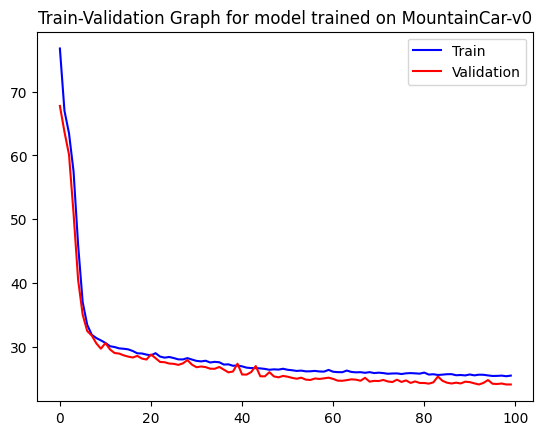

In [ ]:
# train(
#     pretrain_path,
#     pretrain_epochs,
#     pretrain_batch_size,
#     pretrain_optimizer,
#     env,
#     rm,
#     dqn,
#     target_net,
#     optm,
#     batch_size,
#     gamma,
#     device,
#     200,
#     epsilon,
#     target_update,
#     pretrain_done_callback=lambda dqn: test_dqn(dqn, gym.make(env_name, render_mode="rgb_array"), device, output_name="pretrain_mountain_car"),
# )

In [ ]:
# af_rewards = test_dqn(dqn, gym.make(env_name, render_mode="rgb_array"), device, output_name="after_training_mountain_car")